In [1]:
import os
from pathlib import Path
import numpy as np
import matplotlib.pyplot as plt
import tkinter as tk
from tkinter import filedialog
import scipy.io
from matplotlib.gridspec import GridSpec
from matplotlib.patches import Rectangle

from src.eeg_analysis.preprocessing.eeg_file import EEGFile
from src.eeg_analysis.preprocessing.eeg_preprocessor import EEGPreprocessor
from src.eeg_analysis.analysis.power_spectral import PowerSpectralAnalysis
from src.eeg_analysis.visualization.plots import plot_continuous_epochs
from src.eeg_analysis.visualization.my_custom_style import set_custom_style

In [2]:
dataset_dir = 'E:/Caffeine_data'
participant_name = 'CA-01'

In [3]:
def get_eeg_file(dataset_dir=None, participant_name=None):

    if (dataset_dir is not None) & (participant_name is not None):
        eeg_path = Path(f'{dataset_dir}/{participant_name}/{participant_name}').with_suffix('.eeg')
    else: 
        # Create a Tkinter root window (it will not be shown)
        root = tk.Tk()
        root.withdraw()
        
        # Set the file dialog to appear in front
        root.attributes('-topmost', True)

        # Ask the user to select a .eeg file
        eeg_file_path = filedialog.askopenfilename(title="Select EEG File", filetypes=[("EEG files", "*.eeg")])
        if not eeg_file_path:
            raise FileNotFoundError("No file selected.")
        
        # Convert to Path object for easier manipulation
        eeg_path = Path(eeg_file_path)
    
    base_path = eeg_path.with_suffix('')
    base_dir = eeg_path.parent
    
    # Extract participant ID (assuming filename is `CA-XX.eeg`)
    participant_name = base_path.name
    participant_id = int(participant_name.split('-')[1])  # Adjust this if your file naming convention is different
    
    # Generate paths for the corresponding files
    vhdr_path = base_path.with_suffix('.vhdr')
    vmrk_path = base_path.with_suffix('.vmrk')

    return participant_id, base_dir, vhdr_path, vmrk_path, eeg_path

participant_id, base_dir, vhdr_path, vmrk_path, eeg_path = get_eeg_file(dataset_dir, participant_name)

# Make a directory for analysis results
base_results_dir = base_dir / 'analysis_results'
if not base_results_dir.exists():
    base_results_dir.mkdir(parents=True, exist_ok=True)

eeg_file = EEGFile(participant_id, str(vhdr_path), str(vmrk_path), str(eeg_path))
eeg_file.read_vhdr()


In [7]:
dataset_dir = 'E:/Caffeine_data'
participant_names = [f'CA-{id:02}' for id in range(39, 40)] 

total_duration = {}
for participant_name in participant_names:
    
    print(participant_name)

    try:
        participant_id, base_dir, vhdr_path, vmrk_path, eeg_path = get_eeg_file(dataset_dir, participant_name)

        # Make a directory for analysis results
        base_results_dir = base_dir / 'analysis_results_v2'
        if not base_results_dir.exists():
            base_results_dir.mkdir(parents=True, exist_ok=True)

        eeg_file = EEGFile(participant_id, str(vhdr_path), str(vmrk_path), str(eeg_path))
        eeg_file.load_data()
        # eeg_file.read_vmrk()
    except:
        pass

        df = eeg_file.events_df
        loc_start = df.loc[df['name'] == 'loc', 'start'].values[0]
        extubation = df.loc[df['name'] == 'emergence', 'end'].values[0]
        total_duration[participant_name] = extubation - loc_start
        # print(f'Error with {participant_name}')


CA-39
Error reading .eeg file: cannot reshape array of size 5810176 into shape (21)


AttributeError: 'list' object has no attribute 'loc'

##### Load preprocessed .mat EEG data

In [5]:
def load_mat_file(participant_id, epoch, variables, all_channel_names):

    base_dir = Path(r'D:/Anesthesia_Research_Fellow/preprocessed_EEG_by_DuanLI')
    base_filename = f'CA_{participant_id:02}_{epoch}_denoised.mat'
    file_path = base_dir / base_filename

    # Check if the file exists
    if not file_path.exists():
        raise FileNotFoundError(f"The file {file_path} does not exist")

    # Load .mat file
    mat_data = scipy.io.loadmat(file_path)
    

    # Access the variables
    data={}
    for variable in variables:
        if variable in mat_data:
            curr_variable = mat_data[variable]
            if variable in ['zz_epoch', 'zz_noise']:
                data[variable] = np.transpose(curr_variable, [1, 0])
            elif variable in ['channels_remained', 'Index_tt']:
                data[variable] = curr_variable.flatten() - 1 # Due to Python zero-indexing
            elif variable in ['fs', 'L_raw', 'L_denoised']:
                data[variable] = curr_variable.flatten()[0]
            else:
                data[variable] = curr_variable.flatten()
        else:
            print(f"The variable '{variable}' does not exist in the .mat file for epoch '{epoch}'")
    
    # channels_remained = data['channels_remained'].flatten().tolist()
    # data['channel_names'] = [all_channel_names[i] for i in channels_remained]
    # data['omitted_channel_names'] = [item for item in all_channel_names if (item not in data['channel_names']) & (len(item) <= 3)]

    return data



# Example for loading different epochs for participant_id = 1
epoch_names = ['preOP_epoch', 'preExtube', 'PACU_epoch']
new_epoch_names = {
    'preOP_epoch': 'preop_rest',
    'preExtube': 'emergence',
    'PACU_epoch': 'pacu_rest'
}
variables = ['channels_remained', 'fs', 'L_denoised', 'L_raw', 'tt', 'Index_tt', 'zz_epoch', 'zz_noise']
all_channel_names = eeg_file.channel_names

epoch_data = {}
for epoch_name in epoch_names:
    try:
        epoch_data[new_epoch_names[epoch_name]] = load_mat_file(participant_id, epoch_name, variables, all_channel_names)
        
        # Process the loaded data as needed
    except FileNotFoundError as e:
        print(e)


The variable 'L_denoised' does not exist in the .mat file for epoch 'preOP_epoch'
The variable 'L_raw' does not exist in the .mat file for epoch 'preOP_epoch'
The variable 'Index_tt' does not exist in the .mat file for epoch 'preExtube'
The variable 'L_denoised' does not exist in the .mat file for epoch 'PACU_epoch'
The variable 'L_raw' does not exist in the .mat file for epoch 'PACU_epoch'


#### Zero padding the eeg data, so the time dimension is linear (with no missing point)

In [6]:
total_num_eeg_channels = 16

epoch_names = list(epoch_data.keys())
for epoch_name in epoch_names:
    if epoch_name == 'emergence':
        curr_epoch_data = epoch_data[epoch_name]
        tt = curr_epoch_data['tt']
        min_tt = np.min(tt)
        max_tt = np.max(tt)
        
        complete_time_range = np.arange(min_tt, max_tt + 1)
        time_indices = tt - min_tt  # These are the positions where `tt` values should go

        # Preallocate zero-padded EEG data arrays
        for eeg_data_name in ['zz_epoch', 'zz_noise']:
            curr_eeg_data = curr_epoch_data[eeg_data_name]
            zero_padded_eeg = np.zeros((len(complete_time_range), curr_eeg_data.shape[1]))

            # Utilize NumPy indexing to fill in the non-zero data
            zero_padded_eeg[time_indices] = curr_eeg_data

            epoch_data[epoch_name][eeg_data_name] = zero_padded_eeg

        epoch_data[epoch_name]['tt'] = complete_time_range

    else:
        epoch_data[epoch_name]['tt'] = epoch_data[epoch_name]['Index_tt']
        del epoch_data[epoch_name]['Index_tt']


    curr_epoch_data = epoch_data[epoch_name]
    curr_channels_remained = curr_epoch_data['channels_remained']
    for eeg_data_name in ['zz_epoch']: #, 'zz_noise'
        zero_padded_channels = np.zeros((curr_epoch_data['zz_epoch'].shape[0], total_num_eeg_channels))

        for i_chan, chan in enumerate(curr_channels_remained):
            zero_padded_channels[:, chan] = curr_epoch_data[eeg_data_name][:, i_chan]

        epoch_data[epoch_name][eeg_data_name] = zero_padded_channels

    epoch_data[epoch_name]['eliminated_channels'] = [i for i in range(total_num_eeg_channels) if i not in curr_channels_remained.tolist()]
    del epoch_data[epoch_name]['channels_remained']

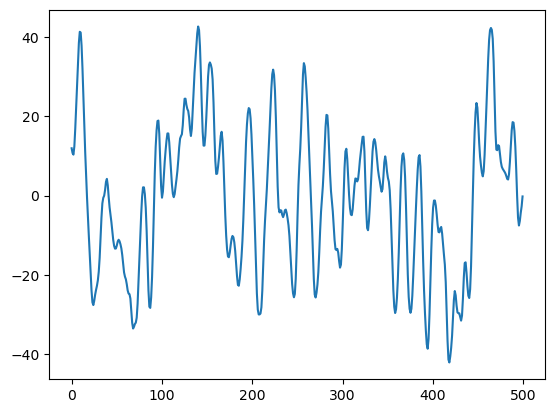

In [7]:
plt.figure()
plt.plot(epoch_data['emergence']['zz_epoch'][:500, 6]) # epoch_data['emergence']['zz_epoch']

#### Generate .eeg file from the imported data for visualizing the eeg using Neuroscope

In [8]:
# epoch_name = 'emergence'
# eeg_data = epoch_data[epoch_name]['zz_epoch']

# sampling_rate = epoch_data[epoch_name]['fs']

# sufffix = f'_{epoch_name}'
# eeg_int = EEGPreprocessor.convert_to_neuroscope_eeg(eeg_data, sampling_rate, eeg_path, sufffix)

##### Modify the eeg_file object using the preprocessed data

In [9]:
epoch_names = epoch_data.keys()

eeg_data = {}
for epoch_name in epoch_names:
    eeg_data[epoch_name] = epoch_data[epoch_name]['zz_epoch']

eeg_file.eeg_data = eeg_data
eeg_file.sampling_frequency = epoch_data[epoch_name]['fs'] 

In [10]:
# eeg_file.eeg_data['emergence'] = eeg_file.eeg_data['emergence'][:150000 ,:]

### Note that the 'emergence' epoch now defined as 10 minutes prior to drug infusion until the extubation 

In [11]:
power_spectral = PowerSpectralAnalysis(eeg_file, step_size=0.1) 

In [12]:
select_epochs = ['preop_rest', 'emergence', 'pacu_rest']
power_spectral.calculate_time_frequency_map(select_channels = None, select_epochs=select_epochs, method='multitaper')

NOTE: tfr_multitaper() is a legacy function. New code should use .compute_tfr(method="multitaper").
NOTE: tfr_multitaper() is a legacy function. New code should use .compute_tfr(method="multitaper").
NOTE: tfr_multitaper() is a legacy function. New code should use .compute_tfr(method="multitaper").


In [13]:
# from src.eeg_analysis.utils.helpers import create_mne_raw_from_data, select_channels_and_adjust_data
# import mne

# sampling_frequency = 250

# select_channels = [1]
# epoch_data = eeg_file.eeg_data['emergence']

# ch_names, ch_types, epoch_data = select_channels_and_adjust_data(epoch_data, select_channels, eeg_file.channel_names, eeg_file.channel_groups)
# raw = create_mne_raw_from_data(
#     data=epoch_data, 
#     channel_names=ch_names, 
#     sampling_frequency=sampling_frequency, 
#     ch_types=ch_types
# )

# freq_resolution = 0.5
# window_size = 2
# step_size = 0.1


# frequencies = np.arange(0.5, 55.5, freq_resolution) 

# window_size_samples = window_size*sampling_frequency if window_size else int(sampling_frequency)
# step_size_samples = step_size*sampling_frequency if step_size else window_size_samples // 2
# nperseg = window_size_samples
# time_step = step_size
# noverlap = (window_size_samples - step_size_samples)/sampling_frequency


# tfr_mne = mne.time_frequency.tfr_multitaper(
#     raw, 
#     freqs=frequencies, 
#     n_cycles=frequencies*2, 
#     time_bandwidth=3, 
#     return_itc=False,
#     average=False,
#     decim=int(sampling_frequency * time_step),
#     verbose=False
# )

# tfr_data = np.transpose(tfr_mne.data, (1, 2, 0))
# tfr_freqs = tfr_mne.freqs
# tfr_times = tfr_mne.times

In [14]:
freqs = power_spectral.tfr['emergence'].frequencies
select_epochs = ['preop_rest', 'emergence', 'pacu_rest']
# select_channels = [4]

avg_psd = {}
for epoch in select_epochs:
    avg_psd[epoch] = np.mean(power_spectral.tfr[epoch].data[:, :, :], axis = (1, 2))
    # avg_psd[epoch] = np.mean(tfr_data, axis = (1,2))

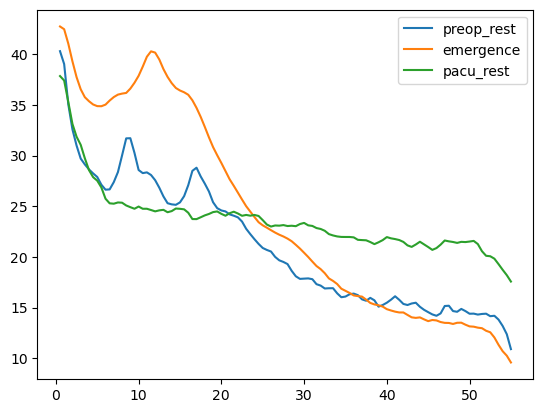

In [15]:
plt.figure()

for epoch in select_epochs:
    plt.plot(freqs, 10*np.log10(avg_psd[epoch]), label=epoch)
    # plt.plot(tfr_freqs, 10*np.log10(avg_psd[epoch]), label=epoch)

plt.legend()

#### Experimenting with IRASA for separating periodic and aperiodic spectral components 

In [16]:
# from neurodsp.spectral import compute_spectrum, trim_spectrum
# from neurodsp.plts import plot_power_spectra

# # Import IRASA related functions
# from neurodsp.aperiodic import compute_irasa, fit_irasa
# psd = avg_psd
# plot_power_spectra(freqs, psd, title="Original Spectrum")

# freqs, psd_aperiodic, psd_periodic = compute_irasa(eeg_file.eeg_data['emergence'][:, 0], 250, f_range=[.5, 55], thresh=10)
# plot_power_spectra(freqs, [psd_aperiodic, psd_periodic],
#                    labels=['aperiodic', 'periodic'], title="IRASA Components")

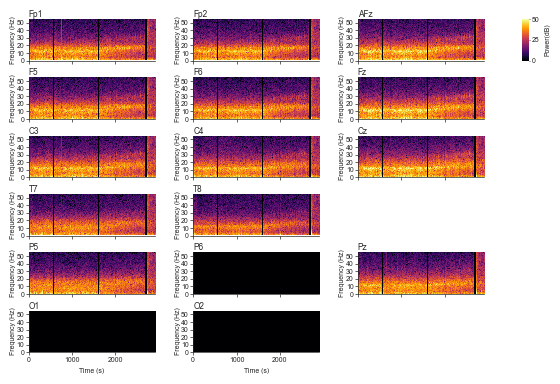

In [17]:
set_custom_style()

epochs_to_include = ['emergence']
# Create a new dictionary with only the specified epochs
tfr_to_plot = {key: value for key, value in power_spectral.tfr.items() if key in epochs_to_include}

start_time = 0
end_time = 0
for _, tfr in tfr_to_plot.items():
    end_time = end_time + tfr.times[-1]

# Plotting for all 16 channels
channels_to_plot = list(range(16))
chan_names = power_spectral.select_channel_names
num_channels = len(channels_to_plot)

group_names = list(power_spectral.channel_groups.keys())
num_groups = len(group_names)

# Define single-column or double_column width figure
fig_width = 450 # Adjusted to fit the 6x3 subplot grid
fig_height = 300 # Adjusted to fit the 6x3 subplot grid

font_size = 6

fig = plt.figure()
fig.set_size_inches([fig_width/72, fig_height/72])
gs = GridSpec(
    nrows=6, 
    ncols=4, 
    figure=fig, 
    wspace = 0.4, 
    hspace = 0.4,
    width_ratios=[1,1,1,0.05]
)

for i_region, region_name in enumerate(group_names):
    region_channels_indices = [chan_names.index(name) for name in chan_names if name in power_spectral.channel_groups[region_name]]
    for i_channel, channel_idx in enumerate(region_channels_indices):
        row = i_region
        col = i_channel
        ax = fig.add_subplot(gs[row, col])

        im = plot_continuous_epochs(tfr_to_plot, ax = ax, colorbar=False, vmin=0, vmax=50, channel = channel_idx, cmap = 'inferno') # vmin=0, vmax = 50 

        if row == 5:  # Label x-axis on the bottom row
            ax.set_xlabel('Time (s)')
        else:
            ax.set_xticklabels([])
        
        ax.set_xticks(np.arange(0, end_time, 1000))
        ax.set_yticks(np.arange(0, 55, 10))
        ax.set_ylabel('Frequency (Hz)', labelpad=0.5)
        ax.set_title(chan_names[channel_idx], pad = 0.5, loc='left')
        ax.tick_params(axis='both', which='major', labelsize=5, length=2, width=0.5, pad=1)

# Add colorbar
cax = fig.add_subplot(gs[0, -1])
cbar = plt.colorbar(im, cax=cax, orientation='vertical')
cbar.set_label('Power(dB)', fontsize=5)
cbar.outline.set_visible(False)
cbar.ax.tick_params(labelsize=5)

plt.subplots_adjust(left=0.1, right= 0.9, bottom=0.1, top=0.9)

# Save plot
base_results_filename = base_results_dir / f'CA-{participant_id:02}'
filename = f'{base_results_filename}_tfrs_preprocessed_better_resolution.pdf'
file_path = os.path.join(base_results_dir, filename)
plt.savefig(file_path, format='pdf', dpi=300)

plt.show()

In [18]:
power_spectral.postprocess_anatomical_region_average()

In [19]:
window_size = 120
step_size = 60

power_spectral.postprocess_time_window_average(window_size=window_size, step_size=step_size, attr_name='region_average_tfr')

##### Calculate FOOOF parameters

In [20]:
# power_spectral.postprocess_aperiodic_paramaters(attr_name='window_average_tfr' )

In [21]:
# initial_fbands = {
#     'delta': [0.5, 4],
#     'theta': [4, 7],
#     'alpha':[7, 14],
#     'beta': [18, 35],
#     'gamma':[35, 55]
# }

# power_spectral.postprocess_periodic_parameters(attr_name='window_average_tfr', aperiodic_mode='knee', fbands=initial_fbands, peak_threshold=0.1, overlap_threshold=0.5)

##### Calculate the aperiodic slope by estimating the slope of the aperiodic component in its linear regime using FOOOF, with the aperiodic mode set to 'knee'

The following code snippet needs to be integrated into the power_spectral.py 

In [22]:
# aperiodic_fit = power_spectral.fooof_aperiodic_fit['prefrontal']['emergence']
# num_time_points = len(aperiodic_fit)
# freqs = power_spectral.frequencies
# idx = np.where(freqs > 10)[0]
# slope = np.full((num_time_points,), np.nan)

# for pnt in range(num_time_points):
#     s, _ = np.polyfit(freqs[idx], 10*aperiodic_fit[(0, pnt)][idx], 1)
#     slope[pnt] = -s

# plt.figure()
# plt.plot(slope)
# plt.tick_params(labelsize=10)
# # plt.ylim([0.01, 0.08])


    
# # plot an example aperiodic fit 
# example_aperiodic_fit = 10 ** (aperiodic_fit)
# diff_aperiodic_fit = np.diff(aperiodic_fit)


# plt.figure()
# # plt.plot(freqs[1:], diff_aperiodic_fit)
# plt.plot(freqs, aperiodic_fit)
# # plt.plot(np.log10(freqs), aperiodic_fit)
# plt.tick_params(labelsize=10)


In [ ]:
power_spectral.postprocess_frequency_domain_whitening(attr_name='region_average_tfr', fbands={
    'delta': [0, 4],
    'theta': [4, 7],
    'alpha':[7, 20],
    'beta': [20, 35],
    'gamma':[35, 55]
})

In [240]:
power_spectral.fooof_periodic_parameters['prefrontal']['emergence']['alpha']['cf']

array([[12.68284304, 12.66263811, 10.96069898, 12.24121829, 10.89024206,
        12.29254135, 12.46120775, 11.3657532 , 11.45181177, 12.41244073,
        10.54770786,         nan,         nan, 12.56886142, 12.7248998 ,
        12.47509615, 11.82104967, 11.74245036, 11.43427254, 12.16676528,
        12.21737508, 11.99784125, 12.17391748, 12.01559982, 12.1048704 ,
        12.49713888, 12.20145522, 10.27717741, 10.42462034, 10.89985736,
        10.70368751, 10.54219594, 12.50543539, 11.84797791, 10.67911032,
        11.13251194, 11.55430177, 10.69087994, 11.6860764 , 12.67270936,
        12.04724375, 10.86634541, 19.84778776, 10.60440788, 13.50248956,
        13.47985796,  9.93196557,  9.9062889 ,  9.83075073,  8.39619344,
         8.466012  , 11.34152133,  9.32759658,  8.34926867, 14.45075239,
                nan,         nan,         nan,         nan,  8.33779554,
         8.2292973 ,         nan,         nan,  8.77413743,  9.19943732]])

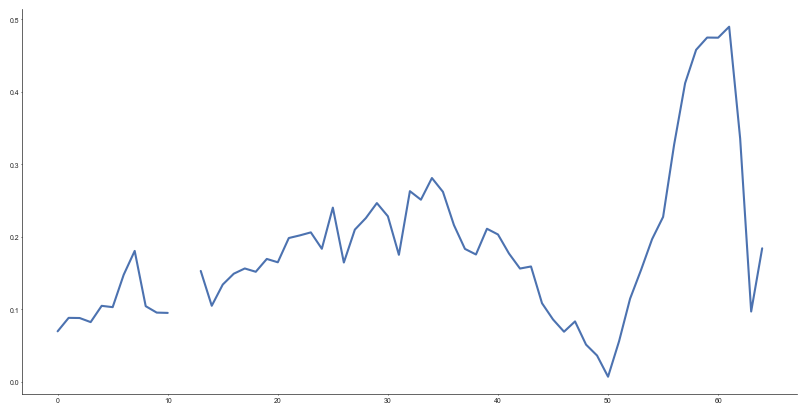

In [245]:
plt.figure(figsize=(10, 5))
plt.plot(power_spectral.fooof_periodic_parameters['prefrontal']['emergence']['beta']['amplitude'][0])

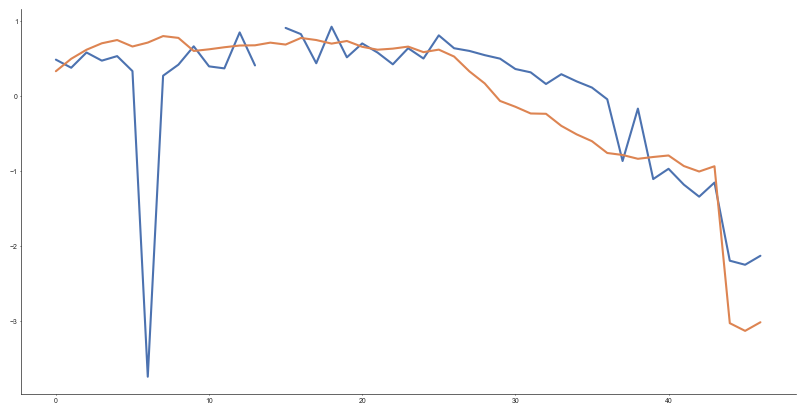

In [48]:
plt.figure(figsize=(10, 5))
reg_slope = -power_spectral.regresssion_ap_fit_slope['prefrontal']['emergence']
reg_slope = (reg_slope-np.nanmean(reg_slope))/np.nanstd(reg_slope)
plt.plot(reg_slope)

# plt.plot(
#     power_spectral.fooof_periodic_parameters['prefrontal']['emergence']['delta']['cf'][0],
#     power_spectral.fooof_periodic_parameters['prefrontal']['emergence']['delta']['amplitude'][0]
# )
# plt.plot(
#     power_spectral.fooof_periodic_parameters['prefrontal']['emergence']['beta']['cf'][0],
#     power_spectral.fooof_periodic_parameters['prefrontal']['emergence']['beta']['amplitude'][0]
# )
fooof_slope = power_spectral.fooof_aperiodic_fit_slope['prefrontal']['emergence'][0]
fooof_slope = (fooof_slope-np.nanmean(fooof_slope))/np.nanstd(fooof_slope)
plt.plot(fooof_slope)


#### Experimenting with FOOOF


FOOOF WARNING: Lower-bound peak width limit is < or ~= the frequency resolution: 0.50 <= 0.50
	Lower bounds below frequency-resolution have no effect (effective lower bound is the frequency resolution).
	Too low a limit may lead to overfitting noise as small bandwidth peaks.
	We recommend a lower bound of approximately 2x the frequency resolution.



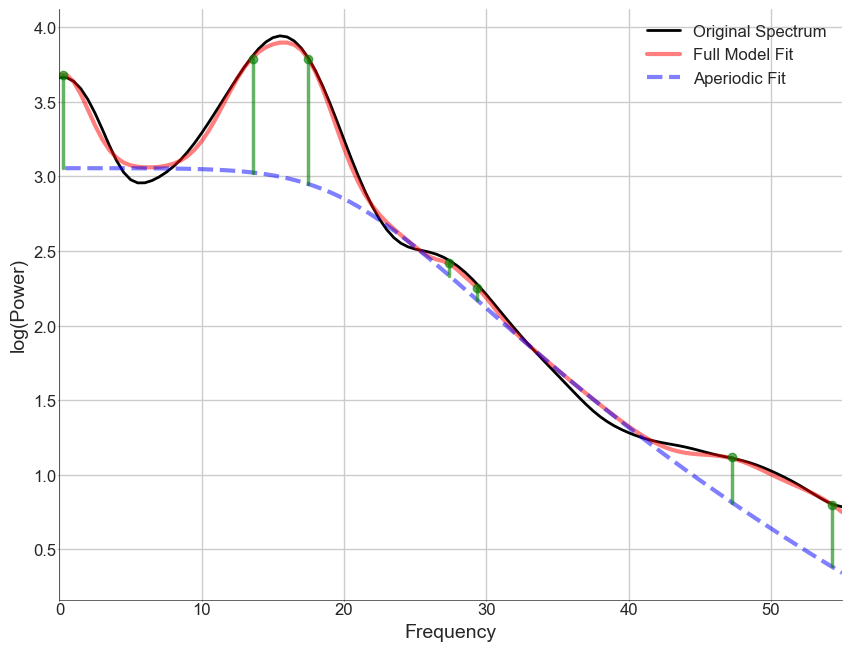

In [42]:
import numpy as np
import matplotlib.pyplot as plt
from fooof import FOOOF

# Example PSD data
frequencies = freqs.copy()  # Example frequency range 
psd = power_spectral.window_average_tfr['prefrontal']['emergence'].data[:, 35, 0]
# psd = avg_psd['preop_rest']  # Example PSD data

# Extend the PSD data by repeating it
freq_4hz = 8
idx_4hz = np.argmin(np.abs(freqs - freq_4hz))
artifical_psd = np.flip(psd[:idx_4hz+1])
extended_psd = np.concatenate([artifical_psd, psd])

extended_frequencies = np.concatenate([np.flip(frequencies[0]-frequencies[:idx_4hz+1]), frequencies])
# make the first frequency value to be 0.5 Hz
start_freq_diff = frequencies[0] - extended_frequencies[0]
extended_frequencies = extended_frequencies + start_freq_diff


# Initialize FOOOF
fm = FOOOF(peak_threshold=0.1, aperiodic_mode='knee')

# Fit the extended PSD
fm.fit(extended_frequencies, extended_psd, freq_range=[extended_frequencies[0], extended_frequencies[-1]])
# fm.fit(frequencies, psd)

# move fm peak params to the original frequency range
fm.peak_params_[:, 0] -= start_freq_diff
fm.freqs -= start_freq_diff

# Plot results with aperiodic fit
fm.plot(plot_peaks='dot', plot_aperiodic=True)
plt.xlim([0, 55])
plt.show()


In [ ]:
plt.figure()
plt.plot(freqs, 10*np.log10(power_spectral.window_average_tfr['prefrontal']['emergence'].data[:, 41]))
plt.xlim([10,20])


In [ ]:
power_spectral.fooof_periodic_parameters['prefrontal']['emergence']['beta']['amplitude'][0][41]

In [ ]:
plt.figure(figsize=(10, 5))

plt.imshow(10*np.log10(power_spectral.region_average_tfr['prefrontal']['emergence'].data), vmin=5, vmax=45, aspect='auto', cmap='inferno', origin='lower')
plt.ylim([0, 55])

In [ ]:
epoch_name = 'emergence'
freqs = power_spectral.frequencies
fbands = {
    'delta': [0.5, 4],
    'theta': [4, 7],
    'alpha':[7, 14],
    'beta': [18, 35],
    'gamma':[35, 55]
}


tfr = power_spectral.window_average_tfr['prefrontal'][epoch_name].data
num_wins = tfr.shape[1]

slope = power_spectral.regresssion_ap_fit_slope['prefrontal'][epoch_name]
intercept = power_spectral.regression_ap_fit_intercept['prefrontal'][epoch_name]
psd_estimated = power_spectral.regression_ap_fit['prefrontal'][epoch_name]
win_included_freq_idx = power_spectral.regression_ap_fit_included_freqs['prefrontal'][epoch_name]

win_idx = 10
psd = tfr[:, win_idx]
psd_db = 10*np.log10(psd).flatten()

# freqs_input = np.log10(freqs) if log_freq_flag==True else freqs 
# psd_estimated = intercept[win_idx] + slope[win_idx] * freqs_input

fig, axs = plt.subplots(nrows=1, ncols=2, figsize = [10,4])
# plot the power spectrum with fit within select frequencies 

axs[0].plot(freqs, psd_db )
axs[0].plot(freqs, psd_estimated[:, win_idx, 0])

axs[0].plot(freqs[win_included_freq_idx[:, win_idx, 0]], psd_db[win_included_freq_idx[:, win_idx, 0]]+0.1, '.', markersize=3, color='k')

for band in fbands:
    curr_band_info = power_spectral.fooof_periodic_parameters['prefrontal'][epoch_name][band]
    lower_bound = curr_band_info['lower_bound'][0, win_idx]
    upper_bound = curr_band_info['upper_bound'][0, win_idx]

    axs[0].axvline(x=lower_bound, color='green', linestyle='-.', linewidth=0.5, alpha=1)
    axs[0].axvline(x=upper_bound, color='red', linestyle='-.', linewidth=0.5, alpha=1)


axs[0].tick_params(labelsize=10)


# plot the time course of fit slope 
axs[1].plot(-slope)
axs[1].tick_params(labelsize=10)

In [ ]:
from fooof import FOOOF
from fooof.sim.gen import gen_aperiodic
from scipy.ndimage import gaussian_filter1d

epoch_name = 'emergence'
freq_range = [0.1, 55]
fit_fooof_to_average_spectrum = False
win_idx = 10

tfr = power_spectral.window_average_tfr['prefrontal'][epoch_name].data
curr_psd = np.squeeze(tfr[:, win_idx])

if fit_fooof_to_average_spectrum == True:
    psd_to_fit = np.squeeze(np.nanmean(tfr, axis=1))
else:
    psd_to_fit = curr_psd

# sigma = 2 
# curr_psd = gaussian_filter1d(curr_psd, sigma)

freqs = power_spectral.frequencies

fooof_model = FOOOF(aperiodic_mode='knee', peak_threshold=1.5, verbose=False)
fooof_model._ap_bounds = ((-np.inf, -np.inf, -np.inf), (np.inf, np.inf, np.inf))
fooof_model.fit(freqs, psd_to_fit, freq_range=freq_range)
print(fooof_model.aperiodic_params_) # [Offset, Knee, Exponent]


# power_spectrum = fooof_model.power_spectrum
fooof_freqs = fooof_model.freqs
curr_psd =curr_psd[(freqs >= freq_range[0]) & (freqs <= freq_range[1])]

fig, axs = plt.subplots(nrows=1, ncols=2, figsize = [10,4])
axs[0].plot(fooof_freqs, np.log10(curr_psd))

aperiodic_fit = gen_aperiodic(fooof_freqs, fooof_model._robust_ap_fit(fooof_model.freqs, fooof_model.power_spectrum))
axs[0].plot(fooof_freqs, aperiodic_fit)
axs[0].tick_params(labelsize=10)


axs[1].plot(fooof_freqs, np.log10(curr_psd) - aperiodic_fit)
axs[1].tick_params(labelsize=10)

for band in fbands:
    curr_band_info = power_spectral.fooof_periodic_parameters['prefrontal'][epoch_name][band]
    lower_bound = curr_band_info['lower_bound'][0][win_idx]
    upper_bound = curr_band_info['upper_bound'][0][win_idx]

    axs[1].axvline(x=lower_bound, color='green', linestyle='-.', linewidth=0.5, alpha=1)
    axs[1].axvline(x=upper_bound, color='red', linestyle='-.', linewidth=0.5, alpha=1)

ff = power_spectral.fooof_periodic_parameters['prefrontal'][epoch_name]['theta']['lower_bound'][0][win_idx]
aa = np.interp(ff , fooof_freqs, np.log10(curr_psd) - aperiodic_fit)
print(aa, ff)

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.gridspec import GridSpec


set_custom_style()

regions = ['prefrontal', 'frontal', 'central', 'temporal', 'parietal', 'occipital']
epoch_name = 'emergence'

frequency_bands = ['delta', 'alpha', 'beta', 'gamma']
greek_band_names = {
    'delta': r'$\delta$',
    'alpha': r'$\alpha$',
    'beta': r'$\beta$',
    'gamma': r'$\gamma$'
}

# Number of regions
num_regions = len(regions)


if power_spectral.fooof_models['prefrontal']['emergence'] is not None:

    # Determine the number of windows from the first region (assuming all regions have the same shape)
    num_windows = len(power_spectral.fooof_models[regions[0]][epoch_name])

    # Determine the grid size for the subplots
    cols_windows = int(np.ceil(np.sqrt(num_windows)))
    rows_windows = int(np.ceil(num_windows / cols_windows))

    # Create a main figure with subplots for each region
    fig_width = 6
    fig_height = 3.5 * num_regions + 0.5 * num_regions
    fig = plt.figure()
    fig.set_size_inches([fig_width, fig_height])
    gs = GridSpec(
        nrows=num_regions * (rows_windows + 2),  # One additional row per region for the title
        ncols=cols_windows,
        figure=fig,
        wspace=0.2,
        hspace=0.3
    )

    # Utility to set common y-limits across all plots for a region
    # def get_common_y_limits(region, num_windows, epoch_name):
    #     all_ylimits = []
    #     for win_idx in range(num_windows):
    #         model = power_spectral.fooof_models[region][epoch_name][0, win_idx]
    #         ylimits = model.plot(plt_log=False, plot_peaks=False, add_legned=False, linewidth=0.5, return_limits=True)
    #         all_ylimits.append(ylimits)
    #     common_ylim = np.min(all_ylimits), np.max(all_ylimits)
    #     return common_ylim

    # Plot each window for each region
    for r_idx, region in enumerate(regions):
        # Add a title for each region spanning all columns
        ax_title = fig.add_subplot(gs[r_idx * (rows_windows + 2)+1, :])
        ax_title.set_title(region.capitalize(), fontsize=10, fontweight='bold', pad=10, loc='left')
        ax_title.axis('off')
        
        # Get common y-limits for the current region
        # common_ylim = get_common_y_limits(region, num_windows, epoch_name)
        curr_fooof_models = power_spectral.fooof_models[region][epoch_name]
        if curr_fooof_models != {}:
            for win_idx in range(num_windows):
                ax = fig.add_subplot(gs[r_idx * (rows_windows + 2) + (win_idx // cols_windows) + 1, win_idx % cols_windows])
                curr_fooof_models[0, win_idx].plot(plt_log=False, plot_peaks=False, add_legned=False, linewidth=0.3, ax=ax)
                
                # Set common y-limits
                # ax.set_ylim(common_ylim)
                ax.set_ylim([0, 5.5])
                ax.set_xticks(np.arange(0, 51, 10))

                yl = ax.get_ylim()
                for idx, fband in enumerate(frequency_bands): 
                    curr_cf = power_spectral.fooof_periodic_parameters[region][epoch_name][fband]['cf'][0][win_idx]
                    ax.axvline(x=curr_cf, color='green', linestyle='-', linewidth=0.3, alpha=0.5)
                    ax.annotate(f'{greek_band_names[fband]} {curr_cf:.1f} Hz', xy=(curr_cf-8, yl[0]+0.05*np.diff(yl)), xytext=(5, 0),
                            textcoords='offset points', rotation=90, va='bottom', ha='left', fontsize=3, color='green', alpha=0.5)

                ax.grid(which='both', linewidth=0.25)
                
                # Set labels based on position
                if win_idx % cols_windows == 0:  # Leftmost column
                    ax.set_ylabel(ax.get_ylabel(), fontsize=5)
                    yticks = ax.get_yticks()
                    ax.set_yticks(yticks)
                    ax.set_yticklabels([f'{y:.1f}' for y in yticks], fontsize=5)
                else:
                    ax.set_ylabel('')
                    ax.set_yticklabels([])

                if win_idx // cols_windows == rows_windows - 1 or ((win_idx // cols_windows == rows_windows - 2) and (win_idx >= num_windows - cols_windows)):  # Last row or second last row with empty bottom
                    ax.set_xlabel(ax.get_xlabel(), fontsize=5)
                    xticks = ax.get_xticks()
                    ax.set_xticks(xticks)
                    ax.set_xticklabels([f'{x:.1f}' for x in xticks], rotation=45, fontsize=5)
                else:
                    ax.set_xlabel('')
                    ax.set_xticklabels([])

                # Remove the legend if it exists
                legend = ax.get_legend()
                if legend:
                    legend.remove()

                ax.set_ylim([0, 5.5])

                ax.set_title(f'win {win_idx}', fontsize=5, fontweight='regular', loc='center', pad=0)

    # Adjust layout
    plt.subplots_adjust(left=0.2, right=0.8, bottom=0.2, top=0.9)

    # Save plot
    base_results_filename = base_results_dir / f'CA-{participant_id:02}'
    filename = f'{base_results_filename}_fooof_models_time_resolved_preprocessed.pdf'
    file_path = os.path.join(base_results_dir, filename)
    plt.savefig(file_path, format='pdf', dpi=300)

    plt.show()

In [ ]:
regions = ['prefrontal', 'frontal', 'central', 'temporal', 'parietal', 'occipital']
epochs = ['emergence']
frequency_bands = ['delta', 'theta', 'alpha', 'beta', 'gamma']
periodic_features = ['cf', 'amplitude', 'bw', 'avg_power_absolute', 'avg_power_relative']
aperiodic_features = ['exponents', 'intercepts']
num_regions = len(regions)
num_bands = len(frequency_bands)
num_periodic_features = len(periodic_features)
num_aperiodic_features = len(aperiodic_features)

epoch_colors = ['#007377', '#483D8B', '#C84E00', '#556B2F']

greek_band_names = {
    'delta': r'$\delta$',
    'theta': r'$\theta$',
    'alpha': r'$\alpha$',
    'beta': r'$\beta$',
    'gamma': r'$\gamma$'
}

full_feature_names = {
    'cf': 'central\nfrequency',
    'amplitude': 'amplitude',
    'bw': 'bandwidth',
    'avg_power_relative': 'mean\nrel. power',
    'avg_power_absolute': 'mean\nabs. power'
}

# Calculate an approximate figure height
fig_width = 6  # inches
fig_height = 3 * num_regions + 0.5 * num_regions  # inches (additional space for region titles)

font_size = 6  # font size for the titles

# Create a figure
fig = plt.figure()
fig.set_size_inches([fig_width, fig_height])
gs = GridSpec(
    nrows=num_regions * (num_bands + 2),  # accounting for extra title rows
    ncols=num_periodic_features+1,
    figure=fig,
    wspace=0.5, 
    hspace=0.2
)

# Loop through each region, band, and feature to create plots
for r_idx, region in enumerate(regions):
    # Create an empty axis for the supertitle of the region
    ax_title = fig.add_subplot(gs[r_idx * (num_bands + 2)+1, :])  # Span all columns
    ax_title.set_title(region.capitalize(), fontsize=10, fontweight='bold', loc='left', pad=18)
    ax_title.axis('off')  # Hide the axis for the region title
    
    for b_idx, band in enumerate(frequency_bands):
        for f_idx, feature in enumerate(periodic_features):
            # Adjust the row index by adding 1 to account for the region title row
            ax = fig.add_subplot(gs[r_idx * (num_bands + 2) + b_idx + 1, f_idx])
            
            # Example data retrieval and plotting (replace accordingly)
            start_shift = 0
            for epoch_idx, epoch in enumerate(epochs):
                parameter_data = power_spectral.fooof_periodic_parameters[region][epoch][band][feature][0]
                window_centers = start_shift + power_spectral.window_average_tfr[region][epoch].times
                start_shift += power_spectral.tfr[epoch].times[-1]

                # Plot the data on the subplot
                if not np.all(np.isnan(parameter_data)):
                    ax.plot(window_centers, parameter_data, linewidth=0.75, color='k', marker='none', markersize=.5) #epoch_colors[epoch_idx]
                    ax.plot(window_centers, [np.nanmedian(parameter_data)]*len(window_centers), linewidth=0.5, linestyle=':', color='k')
                    
                    # Set a dashed vertical line to indicate a change of period
                    # ax.axvline(x=start_shift, color='grey', linestyle='--', linewidth=0.5)

            ax.tick_params(axis='both', which='major', labelsize=5, length=2, width=0.5, pad=1)
            ax.set_xticks(range(0, int(window_centers[-1]), 1000))
            ax.set_xticklabels(ax.get_xticks(), rotation=45)

            # Label the subplot if it's the first column or the last row within a region
            if f_idx == 0:
                ax.set_ylabel(f'{greek_band_names[band]}', labelpad=5, color='k', fontweight='bold', fontsize=6)
            if b_idx == num_bands - 1:
                ax.set_xlabel('Time (s)', labelpad=0)
            if b_idx != num_bands - 1:
                ax.set_xticklabels([])
            if b_idx == 0:
                ax.set_title(f'{full_feature_names[feature].capitalize()}', pad=0)
            

    # Now let's add the exponents and intercepts plots at the end of each region's row span
    # Plot exponents in the next-to-last column
    for ap_idx, aperodic_param in enumerate(aperiodic_features):
        ax = fig.add_subplot(gs[r_idx * (num_bands + 2) + ap_idx+1, -1])

        start_shift = 0
        for epoch_idx, epoch in enumerate(epochs):
            parameter_data = power_spectral.fooof_aperiodic_parameters[region][epoch][aperodic_param][0]
            window_centers = start_shift + power_spectral.window_average_tfr[region][epoch].times
            start_shift += power_spectral.tfr[epoch].times[-1]

            if np.any(~np.isnan(parameter_data)):
                ax.plot(window_centers, parameter_data, linewidth=0.75, color='k', label=epoch, marker='none', markersize=.5)
                ax.plot(window_centers, [np.nanmedian(parameter_data)]*len(window_centers), linewidth=0.5, linestyle=':', color='k')

            # ax.axvline(x=start_shift, color='grey', linestyle='--', linewidth=0.5)
    
        ax.set_ylabel(aperodic_param[:-1].capitalize(), labelpad=0)
        ax.tick_params(axis='both', which='major', labelsize=5, length=2, width=0.5, pad=1)
        ax.set_xticks(range(0, int(window_centers[-1]), 1000))
        ax.set_xticklabels(ax.get_xticks(), rotation=45)

        ylim = ax.get_ylim()
        emergence_data = power_spectral.fooof_aperiodic_parameters[region]['emergence'][aperodic_param][0]
        if np.any(~np.isnan(emergence_data.flatten())):
            ax.set_ylim([np.nanpercentile(emergence_data, 10), ylim[1]])

        if ap_idx == num_aperiodic_features - 1:
            ax.set_xlabel('Time (s)', labelpad=0)
        if ap_idx != num_aperiodic_features - 1:
            ax.set_xticklabels([])

        if (r_idx == 0) and (ap_idx == 0):
            ax.legend(loc='upper left', bbox_to_anchor=(1, 1), fontsize='small')

# Adjust layout
plt.subplots_adjust(left=0.2, right=0.8, bottom=0.2, top=0.9)

# Save plot
base_results_filename = base_results_dir / f'CA-{participant_id:02}'
filename = f'{base_results_filename}_fooof_results_time_resolved_preprocessed_better_resolution.pdf'
file_path = os.path.join(base_results_dir, filename)
plt.savefig(file_path, format='pdf', dpi=300)

plt.show()

In [ ]:
# For the prefrontal area plot the region average time-frequency power together with the power in delta and alpha frequency band over time 

region_average_tfr = power_spectral.whitened_tfr
num_regions = len(region_average_tfr)

epoch_name = 'emergence'
region_name = 'prefrontal'

set_custom_style()
# Define single-column or double_column width figure
fig_width = 200 # Adjusted to fit the 6x3 subplot grid
fig_height = 80 # Adjusted to fit the 6x3 subplot grid

# Define a color map for the frequency bands
frequency_bands = list(power_spectral.fooof_periodic_parameters['prefrontal']['emergence'].keys())

# Create a sequential colormap, 'viridis' for example, excluding the broadband
sequential_cmap = plt.cm.YlOrRd(np.linspace(0.35, 1, len(frequency_bands) - 1))
color_map = {band: sequential_cmap[i] for i, band in enumerate(frequency_bands[:-1])}

font_size = 6

fig = plt.figure()
fig.set_size_inches([fig_width/72, fig_height/72])
gs = GridSpec(
    nrows=2, 
    ncols=2, 
    figure=fig,  
    hspace = 0.2,
    width_ratios=[1,0.05]
)

# Plot region-average TFR for the given region
ax = fig.add_subplot(gs[0, 0])
im = plot_continuous_epochs(region_average_tfr['prefrontal'], ax=ax, vmin=-5, vmax=10, colorbar=False, cmap='inferno', title=region_name)     
ax.set_ylabel('Frequency\n(Hz)')
ax.set_title(region_name.capitalize(), pad = 0.5, loc='left')

ax.set_xticks(range(0, int(region_average_tfr['prefrontal']['emergence'].times[-1]), 1000))
ax.set_xticklabels([])
ax.tick_params(axis='both', which='major', labelsize=5, length=2, width=0.5, pad=1)

ax.set_ylim([0, 40])
ax.set_yticks(range(0, 41, 10))

# Add colorbar
cax = fig.add_subplot(gs[0, -1])
cbar = plt.colorbar(im, cax=cax, orientation='vertical')
cbar.set_label('Power (dB)', fontsize=5)
cbar.outline.set_visible(False)
cbar.ax.tick_params(labelsize=5)

# Plot overlaid power of delta and alpha frequency bands over time
window_centers = power_spectral.window_average_tfr[region][epoch].times
ax_time_series = fig.add_subplot(gs[1, 0])

# all_normal_data = []
for fband in ['delta', 'alpha', 'beta']:
    feature='avg_power_absolute' if fband == 'delta' else 'amplitude'
    parameter_data = power_spectral.fooof_periodic_parameters[region_name][epoch_name][fband][feature][0]
    parameter_data = (parameter_data - np.nanmean(parameter_data))/np.nanstd(parameter_data)

    # pre_drug_infusion_avg = np.nanmean(parameter_data[:6])

    # Plot the data on the subplot
    if (not np.all(np.isnan(parameter_data))): #& (~np.isnan(pre_drug_infusion_avg)):
        # normalized_parameter_data = parameter_data/pre_drug_infusion_avg
        # normalized_parameter_data = (normalized_parameter_data - np.nanmean(normalized_parameter_data))/np.nanstd(normalized_parameter_data)

        # all_normal_data.append(normalized_parameter_data) 
        ax_time_series.plot(window_centers, parameter_data, linewidth=0.5, color=color_map[fband], marker='none', label=greek_band_names[fband], markersize=.5) #epoch_colors[epoch_idx]

ax_time_series.set_xlim(ax.get_xlim())
ax_time_series.set_xticks(range(0, int(region_average_tfr['prefrontal']['emergence'].times[-1]), 1000))

#set_the_ylim
# all_normal_data = np.concatenate(all_normal_data, axis=0)
# all_normal_data = all_normal_data[~np.isnan(all_normal_data)]
# all_normal_data = (all_normal_data - np.mean(all_normal_data))/np.std(all_normal_data)
# yl = [0, 1.05*np.percentile(all_normal_data, 100)]

# ax_time_series.set_ylim(yl)
yl = ax_time_series.get_ylim()

ax_time_series.set_yticks(np.arange(yl[0], yl[1], 1))
ax_time_series.set_ylabel('Power\n(normalized)')
ax_time_series.set_xlabel ('Time (s)')

# Add the rectangle patch to indicate the pre-drug infusion region
from matplotlib.patches import Rectangle
start_time = window_centers[0] - (step_size/2)
end_time = window_centers[5] + (step_size/2)
rect = Rectangle((start_time, yl[0]), end_time - start_time, yl[1]-yl[0], facecolor='gray', alpha=0.2)
ax_time_series.add_patch(rect)

ax.tick_params(axis='both', which='major', labelsize=5, length=2, width=0.5, pad=1)


# Create the legend 
legend_ax = fig.add_subplot(gs[1, -1])
legend_ax.axis('off')
legend_lines, legend_labels = ax_time_series.get_legend_handles_labels()
legend_ax.legend(legend_lines, legend_labels, loc='center', fontsize=font_size)


plt.subplots_adjust(left=0.2, right= 0.8, bottom=0.2, top=0.9)

# Save plot
base_results_filename = base_results_dir / f'CA-{participant_id:02}'
filename = f'{base_results_filename}_prefrontal_emergence_trajectory_better_resolution.pdf'
file_path = os.path.join(base_results_dir, filename)
plt.savefig(file_path, format='pdf', dpi=300)

plt.show()

In [ ]:
region_average_tfr = power_spectral.whitened_tfr
num_regions = len(region_average_tfr)

set_custom_style()
epochs_to_include = ['emergence']
# Create a new dictionary with only the specified epochs
tfr_to_plot = {key: value for key, value in power_spectral.tfr.items() if key in epochs_to_include}
select_epochs = ['emergence']

# freq_bands = power_spectral.fooof_periodic_parameters['prefrontal'][select_epochs[0]].keys()

# Define single-column or double_column width figure
fig_width = 200 # Adjusted to fit the 6x3 subplot grid
fig_height = 300 # Adjusted to fit the 6x3 subplot grid

font_size = 6

fig = plt.figure()
fig.set_size_inches([fig_width/72, fig_height/72])
gs = GridSpec(
    nrows=6, 
    ncols=2, 
    figure=fig, 
    wspace = 0.4, 
    hspace = 0.4,
    width_ratios=[1,0.05]
)

region_count = 0
for region, tfr in region_average_tfr.items(): # region_average_tfr
    ax = fig.add_subplot(gs[region_count, 0])
    im = plot_continuous_epochs(tfr, ax=ax, colorbar=False, vmin=-5, vmax=10, cmap='inferno', title=region) 

    if region == list(region_average_tfr.keys())[-1]:
        ax.set_xlabel('Time (s)')
    else:
        ax.set_xticklabels([])
        
    ax.set_ylabel('Frequency (Hz)')
    ax.set_title(region.capitalize(), pad = 0.5, loc='left')

    
    # for band in freq_bands:
    start_shift = 0
    for epoch in select_epochs:
        window_centers = start_shift + power_spectral.window_average_tfr[region][epoch].times

        # freq_band_info = power_spectral.fooof_periodic_parameters[region][epoch][band]
        # cf = freq_band_info['cf'][0]
        # lower_bound = freq_band_info['lower_bound'][0]
        # upper_bound = freq_band_info['upper_bound'][0]
        
        # # ax.plot(window_centers, cf, linestyle='-', linewidth=0.2, color='w')
        # # ax.plot(window_centers, lower_bound, linestyle=':', linewidth=0.2, color='w')  # Dotted line style
        # # ax.plot(window_centers, upper_bound, linestyle=':', linewidth=0.2, color='w')  # Dotted line style

        start_shift += power_spectral.tfr[epoch].times[-1]

    ax.set_xticks(range(0, int(window_centers[-1]), 1000))
    ax.tick_params(axis='both', which='major', labelsize=5, length=2, width=0.5, pad=1)

    ax.set_ylim([0, 55])
    ax.set_yticks(range(0, 55, 10))
    region_count += 1

# Add colorbar
cax = fig.add_subplot(gs[0, -1])
cbar = plt.colorbar(im, cax=cax, orientation='vertical')
cbar.set_label('Power (dB)', fontsize=5)
cbar.outline.set_visible(False)
cbar.ax.tick_params(labelsize=5)

plt.subplots_adjust(left=0.2, right= 0.8, bottom=0.1, top=0.9)

# Save plot
base_results_filename = base_results_dir / f'CA-{participant_id:02}'
filename = f'{base_results_filename}_tfrs_region_averages_preprocessed_better_resolution.pdf'
file_path = os.path.join(base_results_dir, filename)
plt.savefig(file_path, format='pdf', dpi=300)

plt.show()

In [10]:
participant_id = 1
base_results_dir = Path(f'E:/Caffeine_data/CA-{participant_id:02}/analysis_results_v2')

import pickle
base_results_filename = base_results_dir / f'CA-{participant_id:02}'
filename = f'{base_results_filename}_power_spectral'
file_path = os.path.join(base_results_dir, filename)

# with open(f"{file_path}.pkl", "wb") as file:
#     pickle.dump(power_spectral, file)

In [11]:
with open(f"{file_path}.pkl", "rb") as file:
    loaded_power_spectral = pickle.load(file)

In [ ]:
loaded_power_spectral.averaging_win_size

In [38]:
relative_fband_power = loaded_power_spectral.fband_power_relative_reg_ap['prefrontal']['emergence']['alpha'].flatten()

In [39]:
lq = np.nanpercentile(relative_fband_power, 25)
uq = np.nanpercentile(relative_fband_power, 75)

lc = lq - 1.5*(uq - lq)# low cuttoff
uc = uq + 1.5*(uq - lq) 

In [ ]:
relative_fband_power[(relative_fband_power < lc) | (relative_fband_power > uc)] = np.nan
plt.figure()
plt.plot(relative_fband_power)

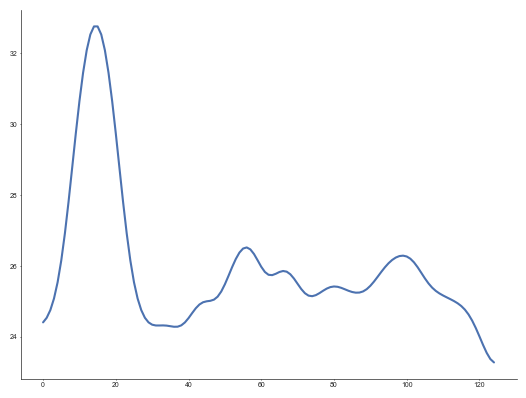

In [47]:
psd = np.array([ 275.39458482,  283.7746868 ,  298.27204428,  321.53757727,
        357.52334155,  411.74068231,  491.06542377,  602.7040137 ,
        752.21508286,  940.57109117, 1160.77321286, 1395.31551498,
       1616.42429288, 1790.57507696, 1886.94431836, 1886.94431836,
       1790.57507696, 1616.42429288, 1395.31551498, 1160.77321286,
        940.57109117,  752.21508286,  602.7040137 ,  491.06542377,
        411.74068231,  357.52334155,  321.53757727,  298.27204428,
        283.7746868 ,  275.39458482,  271.28021201,  269.89793544,
        269.86621524,  270.01513227,  269.62370924,  268.63012192,
        267.65630149,  267.77318388,  270.08425981,  275.24831297,
        283.1047908 ,  292.56966371,  301.90671218,  309.35569387,
        313.90561102,  315.85735985,  316.85334249,  319.30409256,
        325.47062076,  336.65103571,  352.83622173,  372.8460421 ,
        394.69083596,  415.87420591,  433.60216441,  445.11736263,
        448.34024576,  442.68079885,  429.58674426,  412.38337839,
        395.32480968,  382.22635523,  375.26352544,  374.42141564,
        377.74196893,  382.16819744,  384.62351047,  382.95681757,
        376.49787093,  366.11620115,  353.82149175,  342.05625816,
        332.93628153,  327.698481  ,  326.51765053,  328.69570261,
        333.04272175,  338.23035538,  343.01947967,  346.40915557,
        347.79198818,  347.0832014 ,  344.72136724,  341.4784434 ,
        338.18024302,  335.52080325,  334.06169681,  334.31713533,
        336.76863161,  341.74960634,  349.29121134,  359.049415  ,
        370.35026617,  382.31127341,  393.98525626,  404.51655554,
        413.26477119,  419.81739222,  423.85868787,  424.9970793 ,
        422.7279647 ,  416.66007127,  406.89195445,  394.26643083,
        380.27941428,  366.63696633,  354.70928796,  345.16174133,
        337.92009731,  332.42922195,  328.00211467,  324.07451436,
        320.27339596,  316.31206713,  311.83017121,  306.31156502,
        299.1651157 ,  289.94111803,  278.55779028,  265.42322345,
        251.41689883,  237.76134757,  225.83724955,  216.97868283,
        212.25139679])

plt.figure()
plt.plot(10*np.log10(psd))